# Keras Tuner

In [33]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import glob

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from tensorflow import keras

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.12.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preparing filepaths

In [3]:
# set up the folder structure

folder = 'data/dogs-vs-cats/'
train_folder = folder + 'train/'
test_folder = folder + 'test/'

# glob to get the file paths
train_paths = glob.glob(train_folder + '*')
test_paths = glob.glob(test_folder + '*')

In [4]:
# check the file paths

train_paths[0], test_paths[0]

('data/dogs-vs-cats/train/dog.8011.jpg', 'data/dogs-vs-cats/test/9733.jpg')

In [5]:
# define the variables

BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Create test Dataset (no labels)

In [6]:
# load the test dataset, no label extraction needed

def process_test_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [7]:
# build the test dataset

test_paths = tf.data.Dataset.list_files(test_paths, shuffle=False)

test_ds = test_paths.map(process_test_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds

Metal device set to: Apple M3

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [8]:
# check the test dataset

for images in test_ds.take(1):
  print(images.shape)

(32, 224, 224, 3)


2025-04-19 20:35:04.759628: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Extracting train labels from filepath

In [9]:
# get the class label from the filename

image_name = tf.strings.split(train_paths[0], sep='/')
label_tf = tf.strings.split(image_name[-1], sep='.')[0]
label_decoded = label_tf.numpy().decode()
label_decoded


'dog'

In [10]:
# create a dictionary to track the class names

class_names = {0: 'cat', 1: 'dog'}
class_names

{0: 'cat', 1: 'dog'}

In [11]:
# create the a tf function to get the class label from the filename

def get_label(file_path):
  filename = tf.strings.split(file_path, '/')[-1]
  label_str = tf.strings.split(filename, sep='.')[0]

  # map label to integer
  label = tf.where(tf.equal(label_str, 'dog'), 1, 0)
  return label


In [12]:
# create a function to decode the actual images into tensors

def decode_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [13]:
# create function to use the above 2 functions to return image and label pairs

def process_path(file_path):
  label = get_label(file_path)
  image = decode_img(file_path)
  return image, label

# Train/Val Split

In [14]:
# split train and val manually

# shuffle the list
train_paths = tf.random.shuffle(train_paths)

# split 80% train / 20% val
split_idx = int(0.8 * len(train_paths))

train_paths_split = train_paths[:split_idx]
val_paths_split = train_paths[split_idx:]

In [15]:
# create tensorflow datasets

train_ds = tf.data.Dataset.from_tensor_slices(train_paths_split)
val_ds = tf.data.Dataset.from_tensor_slices(val_paths_split)

In [16]:
# for each file path, load and process the image and label
# automatically optimize how many processes it uses to load and process files in parallel

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
# check the train dataset

for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
1


In [18]:
# check the val dataset

for images, labels in val_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
1


# Optimizing the Datasets

In [19]:
# optimize the datasets

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# check train & val

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Keras Tuner

In [20]:
# define the keras tuner function

def tune_model(hp):
  # create the model
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  for _ in range(hp.Int('num_layers', min_value=1, max_value=3)):
    model.add(Conv2D(filters=hp.Int('layer_1_units', min_value=64, max_value=128, step=64),
                     kernel_size=hp.Int('layer_1_kernel_size', min_value=3, max_value=4),
                     strides=hp.Int('layer_1_stride', min_value=1, max_value=2),
                     padding='same',
                     activation=hp.Choice('layer_1_activation', values=['relu', 'tanh'])))
    model.add(Dropout(hp.Float('layer_1_dropout', min_value=0.0, max_value=0.3, step=0.1)))
    model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [21]:
# create the keras tuner

tuner = kt.Hyperband(tune_model, objective='val_loss', max_epochs=10)

Reloading Tuner from ./untitled_project/tuner0.json


In [22]:
# search for best model

# tuner.search(train_ds, validation_data=val_ds, epochs=10)

In [23]:
"""
Trial 22 Complete [00h 03m 43s]
val_loss: 0.36785170435905457

Best val_loss So Far: 0.3338969349861145
Total elapsed time: 03h 34m 38s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_layers
128               |64                |layer_1_units
3                 |3                 |layer_1_kernel_size
2                 |1                 |layer_1_stride
relu              |relu              |layer_1_activation
0                 |0.2               |layer_1_dropout
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round
"""

'\nTrial 22 Complete [00h 03m 43s]\nval_loss: 0.36785170435905457\n\nBest val_loss So Far: 0.3338969349861145\nTotal elapsed time: 03h 34m 38s\n\nSearch: Running Trial #23\n\nValue             |Best Value So Far |Hyperparameter\n1                 |3                 |num_layers\n128               |64                |layer_1_units\n3                 |3                 |layer_1_kernel_size\n2                 |1                 |layer_1_stride\nrelu              |relu              |layer_1_activation\n0                 |0.2               |layer_1_dropout\n10                |10                |tuner/epochs\n0                 |4                 |tuner/initial_epoch\n0                 |1                 |tuner/bracket\n0                 |1                 |tuner/round\n'

In [24]:
# check the results summary of the tuner

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0020 summary
Hyperparameters:
num_layers: 3
layer_1_units: 64
layer_1_kernel_size: 3
layer_1_stride: 1
layer_1_activation: relu
layer_1_dropout: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.3338969349861145

Trial 0012 summary
Hyperparameters:
num_layers: 3
layer_1_units: 128
layer_1_kernel_size: 3
layer_1_stride: 1
layer_1_activation: relu
layer_1_dropout: 0.1
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.3491802513599396

Trial 0021 summary
Hyperparameters:
num_layers: 3
layer_1_units: 64
layer_1_kernel_size: 3
layer_1_stride: 2
layer_1_activation: relu
layer_1_dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0017
Score: 0.36785170435905457

Trial 0018 summary
Hyperparameters:
num_layers: 3
layer_1_un

In [25]:
# check the summary of the best model

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 74, 74, 64)        0         
                                                        

In [26]:
# get the parameters for the best model

best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'num_layers': 3,
 'layer_1_units': 64,
 'layer_1_kernel_size': 3,
 'layer_1_stride': 1,
 'layer_1_activation': 'relu',
 'layer_1_dropout': 0.2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0018'}

In [27]:
"""
{'num_layers': 3,
 'layer_1_units': 64,
 'layer_1_kernel_size': 3,
 'layer_1_stride': 1,
 'layer_1_activation': 'relu',
 'layer_1_dropout': 0.2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0018'}
"""

"\n{'num_layers': 3,\n 'layer_1_units': 64,\n 'layer_1_kernel_size': 3,\n 'layer_1_stride': 1,\n 'layer_1_activation': 'relu',\n 'layer_1_dropout': 0.2,\n 'tuner/epochs': 10,\n 'tuner/initial_epoch': 4,\n 'tuner/bracket': 1,\n 'tuner/round': 1,\n 'tuner/trial_id': '0018'}\n"

In [28]:
# keep training the best model

# history = best_model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=BATCH_SIZE)

In [29]:
"""
Epoch 1/10
625/625 [==============================] - 123s 193ms/step - loss: 0.1884 - accuracy: 0.9230 - val_loss: 0.3490 - val_accuracy: 0.8514
Epoch 2/10
625/625 [==============================] - 120s 192ms/step - loss: 0.1646 - accuracy: 0.9312 - val_loss: 0.3811 - val_accuracy: 0.8434
Epoch 3/10
625/625 [==============================] - 137s 219ms/step - loss: 0.1618 - accuracy: 0.9322 - val_loss: 0.3862 - val_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 130s 208ms/step - loss: 0.1532 - accuracy: 0.9371 - val_loss: 0.4049 - val_accuracy: 0.8402
Epoch 5/10
625/625 [==============================] - 128s 205ms/step - loss: 0.1639 - accuracy: 0.9311 - val_loss: 0.4049 - val_accuracy: 0.8450
Epoch 6/10
625/625 [==============================] - 138s 220ms/step - loss: 0.1300 - accuracy: 0.9469 - val_loss: 0.4229 - val_accuracy: 0.8434
Epoch 7/10
625/625 [==============================] - 132s 212ms/step - loss: 0.1018 - accuracy: 0.9592 - val_loss: 0.4036 - val_accuracy: 0.8590
Epoch 8/10
625/625 [==============================] - 130s 208ms/step - loss: 0.0995 - accuracy: 0.9602 - val_loss: 0.4177 - val_accuracy: 0.8512
"""

'\nEpoch 1/10\n625/625 [==============================] - 123s 193ms/step - loss: 0.1884 - accuracy: 0.9230 - val_loss: 0.3490 - val_accuracy: 0.8514\nEpoch 2/10\n625/625 [==============================] - 120s 192ms/step - loss: 0.1646 - accuracy: 0.9312 - val_loss: 0.3811 - val_accuracy: 0.8434\nEpoch 3/10\n625/625 [==============================] - 137s 219ms/step - loss: 0.1618 - accuracy: 0.9322 - val_loss: 0.3862 - val_accuracy: 0.8472\nEpoch 4/10\n625/625 [==============================] - 130s 208ms/step - loss: 0.1532 - accuracy: 0.9371 - val_loss: 0.4049 - val_accuracy: 0.8402\nEpoch 5/10\n625/625 [==============================] - 128s 205ms/step - loss: 0.1639 - accuracy: 0.9311 - val_loss: 0.4049 - val_accuracy: 0.8450\nEpoch 6/10\n625/625 [==============================] - 138s 220ms/step - loss: 0.1300 - accuracy: 0.9469 - val_loss: 0.4229 - val_accuracy: 0.8434\nEpoch 7/10\n625/625 [==============================] - 132s 212ms/step - loss: 0.1018 - accuracy: 0.9592 - va

In [30]:
# define a function to plot history

def plot_history(history):
  for metric in history.history.keys():
    if not metric.startswith('val'):        # if it doesn't start with val
      plt.plot(history.history[metric], label=metric)
      if f'val_{metric}' in history.history.keys():     # if val is in the keys, then plot that as well
        plt.plot(history.history[f'val_{metric}'], label=f'val+{metric}')
      plt.title(metric)
      plt.legend()
      plt.show()

In [40]:
# re-create the best model using the best parameters

def build_best_model():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [42]:
# create the model

tuned_best_model = build_best_model()
tuned_best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 dropout_7 (Dropout)         (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 64)        0         
                                                      

In [43]:
# fit the model

history = tuned_best_model.fit(train_ds,
                              validation_data=val_ds,
                              epochs=10,
                              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
625/625 [==============================] - 120s 191ms/step - loss: 0.5862 - accuracy: 0.6794 - val_loss: 0.5317 - val_accuracy: 0.7344
Epoch 2/10
625/625 [==============================] - 118s 188ms/step - loss: 0.4762 - accuracy: 0.7757 - val_loss: 0.4454 - val_accuracy: 0.7984
Epoch 3/10
625/625 [==============================] - 121s 193ms/step - loss: 0.4075 - accuracy: 0.8153 - val_loss: 0.4101 - val_accuracy: 0.8244
Epoch 4/10
625/625 [==============================] - 120s 191ms/step - loss: 0.3565 - accuracy: 0.8418 - val_loss: 0.3849 - val_accuracy: 0.8288
Epoch 5/10
625/625 [==============================] - 124s 199ms/step - loss: 0.3071 - accuracy: 0.8651 - val_loss: 0.3737 - val_accuracy: 0.8386
Epoch 6/10
625/625 [==============================] - 123s 196ms/step - loss: 0.2680 - accuracy: 0.8863 - val_loss: 0.3435 - val_accuracy: 0.8542
Epoch 7/10
625/625 [==============================] - 125s 200ms/step - loss: 0.2358 - accuracy: 0.9027 - val_loss: 0.3344 -

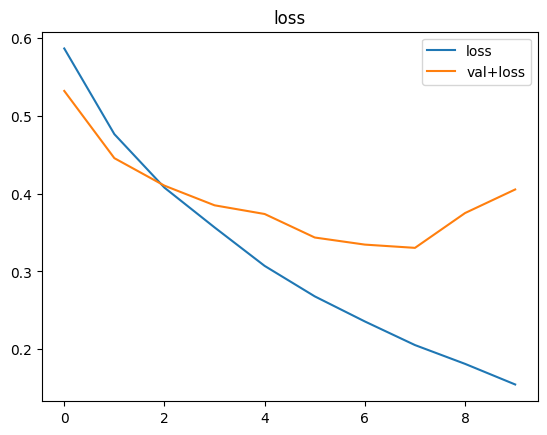

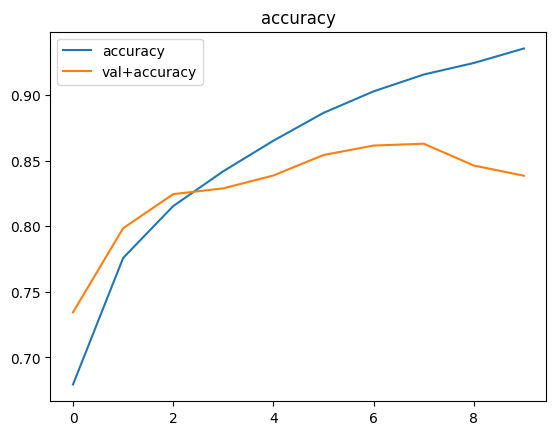

In [44]:
# plot the metrics for the best model

plot_history(history)

/Users/annahan/miniforge3/envs/tf-metal/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


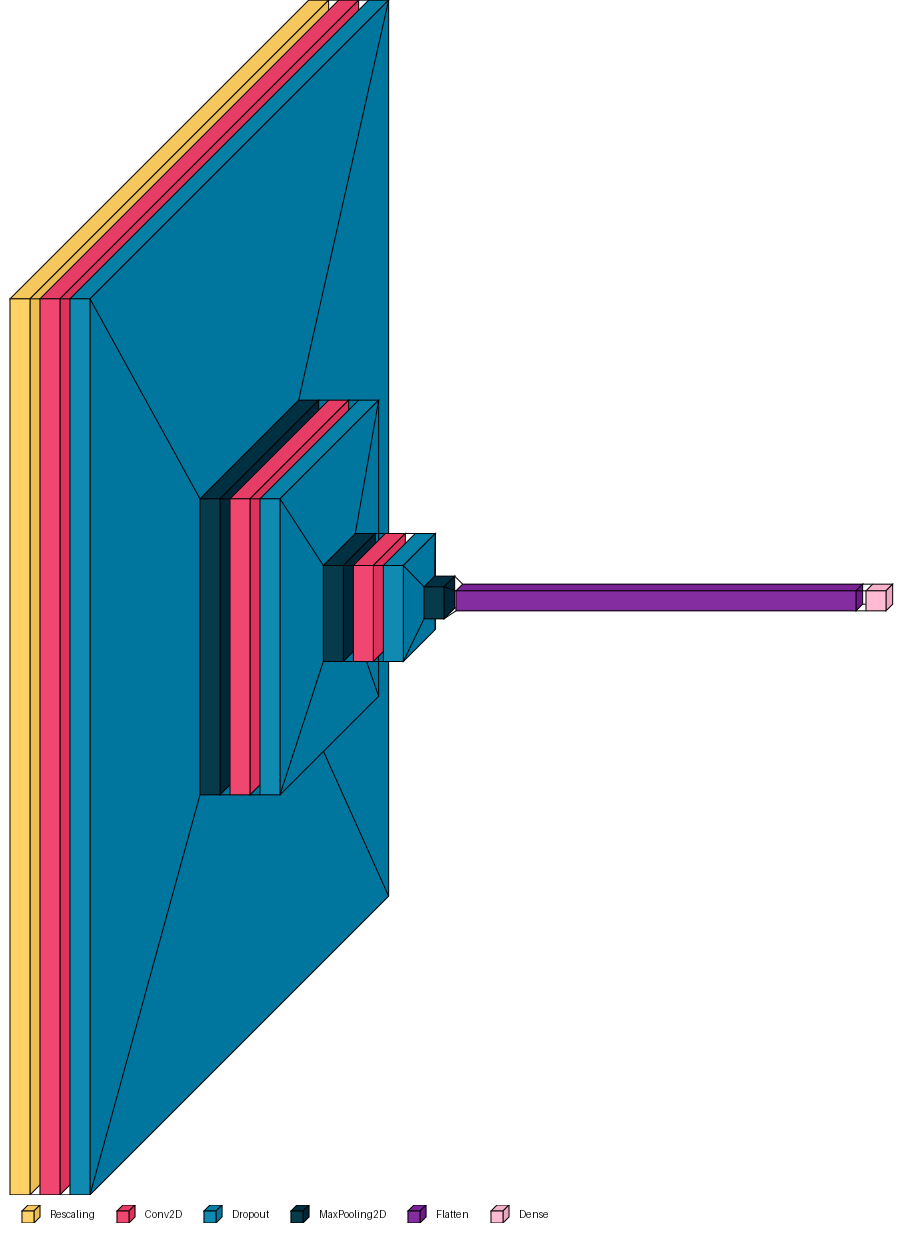

In [45]:
# use visualkeras to visualize the model

import visualkeras as vk

vk.layered_view(tuned_best_model, legend=True)

In [53]:
# get the predictions for val

val_pred = tuned_best_model.predict(val_ds)
val_pred

157/157 [==============================] - 7s 43ms/step


array([[2.1611629e-03, 9.9783891e-01],
       [8.0035435e-04, 9.9919969e-01],
       [1.1121938e-01, 8.8878059e-01],
       ...,
       [1.0028557e-02, 9.8997140e-01],
       [8.3245003e-01, 1.6755001e-01],
       [7.1501628e-02, 9.2849839e-01]], dtype=float32)

In [47]:
# get the predictions

y_pred = tuned_best_model.predict(test_ds)
y_pred

391/391 [==============================] - 17s 42ms/step


array([[0.01593756, 0.9840625 ],
       [0.9240736 , 0.07592637],
       [0.9334557 , 0.06654424],
       ...,
       [0.01346171, 0.9865383 ],
       [0.97693104, 0.02306899],
       [0.35355085, 0.6464491 ]], dtype=float32)

In [48]:
y_pred2 = np.argmax(y_pred, axis=1)

In [51]:
y_pred2[:10]

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0])